# Markov Chain Monte Carlo Example 2
Author: Michael D. Shields
Date: May 15, 2018

In this example, the Metropolis-Hastings, component-wise modified Metropolis-Hastings, and affine invariant ensemble sampler with stretch moves are employed to generate samples from a Rosenbrock distribution. The method illustrates various aspects of the UQpy MCMC class. In these illustrations, the Rosenbrock pdf is defined using a custom distribution script located in the current working directory. For examples where the pdf is defined directly in the script as a python function, see MCMC_Example1.

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the MCMC class from UQpy.

In [1]:
from UQpy.SampleMethods import MCMC
import numpy as np
import matplotlib.pyplot as plt
import time

First, a note on the definition of the target pdf: it can be defined by passing as argument the name of the script defining the custom distribution, here 'Rosenbrock'. This string can be passed into input parameters pdf_target or log_pdf_target: the former will instantiate a Distribution object and call its pdf method, the latter will instantiate a Distribution object and call its log_pdf method. The script defined in Rosenbrock.py does not possess a log_pdf method, thus if we try to pass log_pdf_target='Rosenbrock' an error is raised.

In [2]:
# This call works
x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1.,1.],
         pdf_target='Rosenbrock', pdf_target_params = [20], algorithm='MH', jump=1000, nsamples=100, seed=None)

# This one does not: catch the error
try:
    x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1.,1.],
             log_pdf_target='Rosenbrock', pdf_target_params = [20], algorithm='MH', jump=1000, nsamples=100, seed=None)
except AttributeError as e:
    print('The code cannot run because Rosenbrock.py does not possess a log_pdf method !!!!, '
          'the following error will be raised')
    print(e)

The code cannot run because Rosenbrock.py does not possess a log_pdf method !!!!, the following error will be raised
log_pdf_target given as a string must point to a Distribution with an existing log_pdf method.


In the following, the three algorithms supported by UQpy are compared.

Run MCMC using the defined Rosenbrock distribution for 100 samples using the component-wise modified Metropolis-Hastings Algorithm. Here we use the following parameters.
    - Normal proposal pdf with unit variance.
    - Samples are accepted/rejected based on the ratio of the joint pdf. This is necessary as the dependence of the Rosenbrock pdf does not allow us to accept/reject based on independent marginals.
    - Notice that pdf_target references the Rosenbrock function from 'custom_pdf.py' and therefore it must be defined as a string.
    - A jumping with of 1000 samples. 
    - Seed value is set to the default.
    - No burn (nburn) is specified.
These samples serve as the seed values for MCMC using the affine invariant ensemble sampler with stretch moves.

In [3]:
x = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1.,1.], pdf_target_type='joint_pdf',
         pdf_target='Rosenbrock', pdf_target_params = [20], algorithm='MMH', jump=1000, nsamples=100, seed=None)

Run MCMC using the defined Rosenbrock distribution to generate 1000 samples using the affine invariant ensemble sampler with stretch moves. Note the following:
    - The scale parameter for the stretch moves is set to 2. This is standard from the literature. (Goodman and Weare, 2010). 
    - x.samples, the 100 samples generated above, are used as the seed for the stretch algorithm. This means we propagate an ensemble of size 100.

In [4]:
t = time.time()
z = MCMC(dimension=2, pdf_proposal_type=None, pdf_proposal_scale=2, pdf_target_type='joint_pdf',
         pdf_target='Rosenbrock', pdf_target_params=[20], algorithm='Stretch', jump=1000, nsamples=1000, seed=x.samples)
t_stretch = time.time()-t
print(t_stretch)

73.26686072349548


Run MCMC to generate 1000 samples from the Rosenbrock distribution using the component-wise modified Metropolis-Hastings algorithm and jumping width of 1000 samples for comparison with the stretch MCMC. Note the following:
    - pdf_proposal_scale = 1. This assigns a unit standard deviation to both dimensions without explicitly specifying each dimension, as was the case in the previous call of the MMH algorithm.

In [5]:
t2 = time.time()
y = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=1, pdf_target_type='joint_pdf',
         pdf_target='Rosenbrock', pdf_target_params=[20], algorithm='MMH', jump=1000, nsamples=1000, seed=None)
t_MMH = time.time()-t2
print(t_MMH)

108.57260394096375


Run MCMC to generate 1000 samples from the Rosenbrock distribution using the conventional Metropolis-Hastings algorithm and jumping width of 1000 samples for comparison with the stretch MCMC and MMH.

In [6]:
t3 = time.time()
w = MCMC(dimension=2, pdf_proposal_type='Normal', pdf_proposal_scale=[1,1], pdf_target_type='joint_pdf',
         pdf_target='Rosenbrock', pdf_target_params=[20], algorithm='MH', jump=1000, nsamples=1000, seed=None)
t_MH = time.time()-t3
print(t_MH)

49.2527916431427


Notice the difference in computational expense.
    - The affine invariant ensemble sampler is the least expensive computationally, but requires and ensemble of seed samples.
    - The MMH comes at slightly larger computational expense, but requires only one seed sample.
    - The MH is computationally burdensome. This is caused by the large effort required by the built-in python multivariate normal pdf evaluation.

Plot the sample sets from 'stretch', 'MMH', and 'MH' for comparison

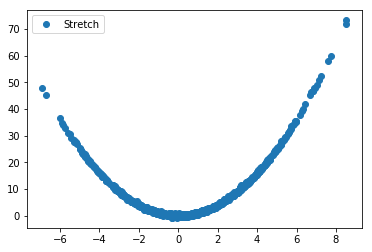

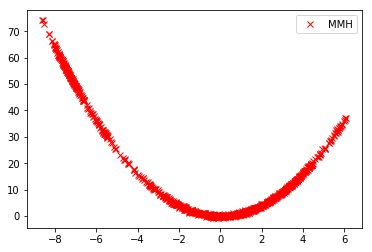

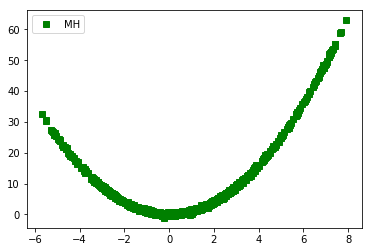

In [7]:
plt.plot(z.samples[:,0],z.samples[:,1],'o')
plt.legend(['Stretch'])
plt.show()
plt.plot(y.samples[:,0],y.samples[:,1],'rx')
plt.legend(['MMH'])
plt.show()
plt.plot(w.samples[:,0],w.samples[:,1],'gs')
plt.legend(['MH'])
plt.show()

A note on the distribution of samples:
    - For this distribution, the MH and MMH algorithms have very long correlation length (~100,000 samples, see Goodman and Weare, 2010). As a result, the affine invariant sampler with stretch moves produces a set of samples that is less correlated given a fixed jumping width of 1000 samples. 